In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
import rtree

import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 500)

## Event Listing

In [2]:
event_list_df = pd.read_csv("data/NYC_Parks_Events_Listing___Event_Listing.csv", parse_dates=True)

In [3]:
event_list_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68689 entries, 0 to 68688
Data columns (total 15 columns):
event_id                68689 non-null int64
title                   68689 non-null object
date                    68689 non-null object
start_time              68689 non-null object
end_time                68689 non-null object
location_description    13059 non-null object
description             68685 non-null object
snippet                 68385 non-null object
phone                   53482 non-null object
email                   47694 non-null object
cost_free               68689 non-null int64
cost_description        13807 non-null object
must_see                68689 non-null int64
url                     68687 non-null object
notice                  68689 non-null int64
dtypes: int64(4), object(11)
memory usage: 7.9+ MB


In [4]:
event_list_df['start_time'] = pd.to_datetime(event_list_df['start_time'], format='%H:%M')

In [5]:
event_list_df[event_list_df.end_time == '24:00']

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice
11088,79666,New Year's Eve Fireworks in Prospect Park,12/31/2013,1900-01-01 23:00:00,24:00,NaN,<p>\n\tStart the celebrations off around 11 p....,Start the celebrations off around 11 p.m. with...,NaN,NaN,1,NaN,1,new-years-eve-fireworks1,0
23359,102431,New Year's Eve Fireworks,12/31/2014,1900-01-01 23:00:00,24:00,NaN,<p>Kick off the New Year&#39;s with this belov...,Kick off the New Year's with this beloved Broo...,NaN,NaN,1,NaN,1,new-years-eve-fireworks,0


In [6]:
event_list_df = event_list_df.drop(event_list_df.index[23359])
event_list_df = event_list_df.drop(event_list_df.index[11088])

In [7]:
event_list_df[event_list_df.end_time == '24:00']

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice


In [8]:
event_list_df['end_time'] = pd.to_datetime(event_list_df['end_time'], format='%H:%M')

In [9]:
event_list_df['date'] = pd.to_datetime(event_list_df.date)

In [10]:
agg_df = event_list_df[event_list_df.date.dt.year == 2017]

In [11]:
agg_df.head()

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice
26877,107941,Conference House Art Expo 2017,2017-05-20,1900-01-01 11:00:00,1900-01-01 17:00:00,NaN,<p>Come view original artworks and tree instal...,Come view original artworks and tree installat...,(718) 984-6046,admin@conferencehouse.org,1,NaN,0,resiliency-and-elements,0
27651,108867,Thursday Evening Hours at the Merchant’s House...,2017-01-05,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0
27652,108868,Thursday Evening Hours at the Merchant’s House...,2017-01-12,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0
27653,108869,Thursday Evening Hours at the Merchant’s House...,2017-01-19,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0
27654,108870,Thursday Evening Hours at the Merchant’s House...,2017-01-26,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0


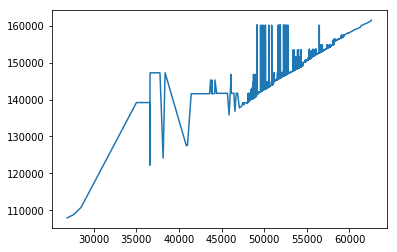

In [12]:
plt.plot(agg_df.event_id);

## Event Location

In [13]:
loc_df = pd.read_csv('data/NYC_Parks_Events_Listing___Event_Locations.csv')

In [14]:
loc_df.head()

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1
0,62223,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"
1,62224,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"
2,62225,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"
3,62226,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"
4,62227,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"


In [15]:
loc_df.shape

(87092, 10)

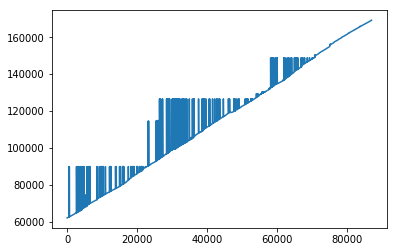

In [16]:
plt.plot(loc_df.event_id)

In [17]:
loc_df[loc_df.event_id == 141581]

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1
65098,141581,Gracie Mansion,M081,40.776001,-73.9431,"88th Street & East End Avenue, Carl Schurz Park",10007.0,M,NaN,"(40.77600097656250000, -73.94309997558594000)"


In [18]:
loc_df[loc_df.event_id == 108869]

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1
38358,108869,Merchant's House Museum,M318,40.727699,-73.992302,29 East 4th Street,10003.0,M,0.0,"(40.72769927978515600, -73.99230194091797000)"


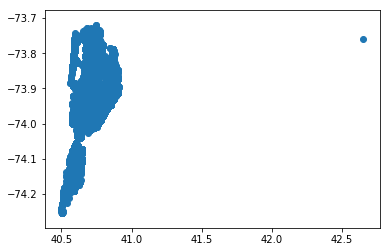

In [19]:
plt.scatter(loc_df.lat, loc_df.long)

https://towardsdatascience.com/geospatial-operations-at-scale-with-dask-and-geopandas-4d92d00eb7e8

In [21]:
df = gpd.read_file('data/taxizones/taxi_zones.shp').to_crs({'init': 'epsg:4326'})
df = df.drop(['Shape_Area', 'Shape_Leng', 'OBJECTID'], axis=1)
gpd.sjoin(gpd.GeoDataFrame(crs={'init': 'epsg:4326'},
    geometry=[Point(-73.9431, 40.776001)]), 
    df, how='left', op='within')

,geometry,index_right,zone,LocationID,borough
0,POINT (-73.9431 40.776001),261,Yorkville East,262,Manhattan


In [24]:
def assign_taxi_zones(df, lon_var, lat_var, locid_var):
    """Joins DataFrame with Taxi Zones shapefile.
    This function takes longitude values provided by `lon_var`, and latitude
    values provided by `lat_var` in DataFrame `df`, and performs a spatial join
    with the NYC taxi_zones shapefile. 
    The shapefile is hard coded in, as this function makes a hard assumption of
    latitude and longitude coordinates. It also assumes latitude=0 and 
    longitude=0 is not a datapoint that can exist in your dataset. Which is 
    reasonable for a dataset of New York, but bad for a global dataset.
    Only rows where `df.lon_var`, `df.lat_var` are reasonably near New York,
    and `df.locid_var` is set to np.nan are updated. 
    Parameters
    ----------
    df : pandas.DataFrame or dask.DataFrame
        DataFrame containing latitudes, longitudes, and location_id columns.
    lon_var : string
        Name of column in `df` containing longitude values. Invalid values 
        should be np.nan.
    lat_var : string
        Name of column in `df` containing latitude values. Invalid values 
        should be np.nan
    locid_var : string
        Name of series to return. 
    """

    import geopandas
    from shapely.geometry import Point


    # make a copy since we will modify lats and lons
    localdf = df[[lon_var, lat_var]].copy()
    
    # missing lat lon info is indicated by nan. Fill with zero
    # which is outside New York shapefile. 
    localdf[lon_var] = localdf[lon_var].fillna(value=0.)
    localdf[lat_var] = localdf[lat_var].fillna(value=0.)
    

    shape_df = geopandas.read_file('data/taxizones/taxi_zones.shp')
    shape_df.drop(['OBJECTID', "Shape_Area", "Shape_Leng", "borough", "zone"],
                  axis=1, inplace=True)
    shape_df = shape_df.to_crs({'init': 'epsg:4326'})

    try:
        local_gdf = geopandas.GeoDataFrame(
            localdf, crs={'init': 'epsg:4326'},
            geometry=[Point(xy) for xy in
                      zip(localdf[lon_var], localdf[lat_var])])

        local_gdf = geopandas.sjoin(
            local_gdf, shape_df, how='left', op='within')
#         return local_gdf
        return local_gdf.LocationID.rename(locid_var)
    except ValueError as ve:
        print(ve)
        print(ve.stacktrace())
        series = localdf[lon_var]
        series = np.nan
    return series

In [26]:
loc_df['taxi_zone'] = assign_taxi_zones(loc_df, 'long', 'lat', 'taxi_zones')

In [27]:
map_df = gpd.read_file('data/newyorkzonemap/geo_export_83da3a04-bfe1-4338-bd66-aa8fff31dec0.shp')

KeyboardInterrupt: 

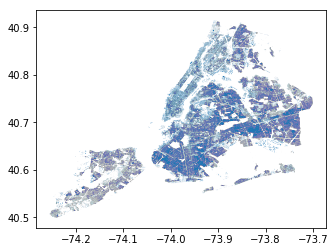

In [31]:
map_df.plot()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87092 entries, 0 to 87091
Data columns (total 11 columns):
event_id      87092 non-null int64
name          87091 non-null object
park_id       75914 non-null object
lat           87092 non-null float64
long          87092 non-null float64
address       45231 non-null object
zip           54184 non-null float64
borough       85773 non-null object
accessible    47854 non-null float64
Location 1    87092 non-null object
taxi_zone     86506 non-null float64
dtypes: float64(5), int64(1), object(5)
memory usage: 7.3+ MB


## Taxi Trip Data

In [20]:
import random

filename = "data/2017_Green_Taxi_Trip_Data.csv"
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 10000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
taxi_df = pd.read_csv(filename, skiprows=skip)

In [21]:
# taxi_df = pd.read_csv('2017_Green_Taxi_Trip_Data.csv', nrows=10000)

In [22]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
VendorID                 10000 non-null int64
lpep_pickup_datetime     10000 non-null object
lpep_dropoff_datetime    10000 non-null object
store_and_fwd_flag       10000 non-null object
RatecodeID               10000 non-null int64
PULocationID             10000 non-null int64
DOLocationID             10000 non-null int64
passenger_count          10000 non-null int64
trip_distance            10000 non-null float64
fare_amount              10000 non-null float64
extra                    10000 non-null float64
mta_tax                  10000 non-null float64
tip_amount               10000 non-null float64
tolls_amount             10000 non-null float64
ehail_fee                0 non-null float64
improvement_surcharge    10000 non-null float64
total_amount             10000 non-null float64
payment_type             10000 non-null int64
trip_type                10000 non-null int64
d

In [23]:
taxi_df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
0,2,01/01/2017 12:15:56 AM,01/01/2017 12:40:27 AM,N,1,33,161,2,7.09,25.0,0.5,0.5,0.00,0.0,NaN,0.3,26.30,2,1
1,2,01/01/2017 01:25:26 AM,01/01/2017 01:30:15 AM,N,1,70,173,3,0.68,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1
2,2,01/01/2017 01:55:50 AM,01/01/2017 02:14:20 AM,N,1,260,49,1,6.32,20.5,0.5,0.5,5.45,0.0,NaN,0.3,27.25,1,1
3,2,01/01/2017 01:08:27 AM,01/01/2017 01:20:39 AM,N,1,129,70,6,2.36,10.0,0.5,0.5,0.00,0.0,NaN,0.3,11.30,2,1
4,2,01/01/2017 01:43:22 AM,01/01/2017 02:07:10 AM,N,1,25,80,1,3.58,17.5,0.5,0.5,3.76,0.0,NaN,0.3,22.56,1,1


In [24]:
taxi_df['lpep_pickup_datetime'] = pd.to_datetime(taxi_df.lpep_pickup_datetime)

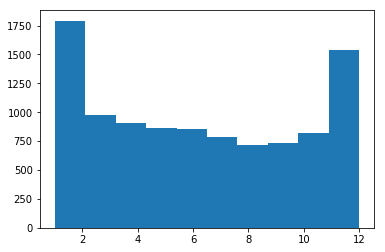

In [25]:
plt.hist(taxi_df.lpep_pickup_datetime.dt.month);